In [59]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F 
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")
print(f"PyTorch Version: {torch.__version__}")
print(f"Torchvision Version: {torchvision.__version__}")

torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

import warnings
warnings.filterwarnings("ignore")

PyTorch Version: 2.3.0+cu118
Torchvision Version: 0.18.0+cu118
Using device: cuda


### Variational Autoencoders (VAEs)
<p>VAEs are a type of generative model. Unlike standard autoencoders that learn a deterministic mapping to a latent space, VAEs learn a probability distribution for that latent space.</p>
<p>Goal:</p>

- Learn a good latent representation.
- Be able to generate new data samples similar to the training data by sampling from the latent space and passing it through the decoder.

<p>VAEs are trained by maximizing the Evidence Lower Bound (ELBO) on the log-likelihood of the data.</p>

In [60]:
transform_vae = transforms.Compose([
    transforms.ToTensor()
])

In [61]:
batch_size = 128

In [62]:
train_dataset = torchvision.datasets.FashionMNIST(root="./data", train=True, download=True, transform=transform_vae)
test_dataset = torchvision.datasets.FashionMNIST(root="./data", train=False, download=True, transform=transform_vae)

In [63]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [64]:
img_channels, img_height, img_width = train_dataset[0][0].shape
img_channels, img_height, img_width 

(1, 28, 28)

In [65]:
flatten_dim = img_channels * img_height * img_width
flatten_dim

784

In [66]:
# visualize data
def imshow_vae(tensor_img, title=None, num_images=8, recon=False):
    tensor_img = tensor_img[:num_images].cpu().detach()
    grid_img = torchvision.utils.make_grid(tensor_img, nrow=num_images)
    plt.imshow(grid_img.permute(1, 2, 0).squeeze(), cmap='gray')
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

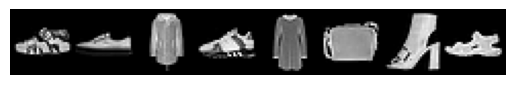

In [67]:
dataiter_vae = iter(train_loader)
images_sample, _ = next(dataiter_vae)
imshow_vae(images_sample)

### VAE model definition (Fully Connected)
<p>Architecture:

- Encoder: Input -> FC Layers -> mu (mean), log_var (log variance) of latent distribution
- Reparameterization Trick: z = mu + sigma * epsilon
- Decoder: Latent z -> FC Layers -> Reconstructed Output</p>

In [68]:
# latent_dim = 20
latent_dim = 2      # train with 2 to visualize 2D Latent space

In [69]:
class VAE(nn.Module):
    
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, latent_dim):
        super(VAE, self).__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim

        # encoder
        self.encoder_fc1 = nn.Linear(input_dim, hidden_dim1)
        self.encoder_fc2 = nn.Linear(hidden_dim1, hidden_dim2)

        # two output layers from encoder: one for mean (mu), one for log_variance (log_var)
        self.fc_mu = nn.Linear(hidden_dim2, latent_dim)
        self.fc_log_var = nn.Linear(hidden_dim2, latent_dim)

        # decoder
        self.decoder_fc1 = nn.Linear(latent_dim, hidden_dim2)
        self.decoder_fc2 = nn.Linear(hidden_dim2, hidden_dim1)
        self.decoder_fc_out = nn.Linear(hidden_dim1, input_dim)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()     # output layer to match input [0,1] range

    def encode(self, x_flat):
        # x_flat -> [batch_size, input_dim]
        h1 = self.relu(self.encoder_fc1(x_flat))
        h2 = self.relu(self.encoder_fc2(h1))
        mu = self.fc_mu(h2)
        log_var = self.fc_log_var(h2)
        return mu, log_var

    def reparameterize(self, mu, log_var):
        # z = mu + sigma * epsilon, where epsilon ~ N(0, I)
        std = torch.exp(0.5 * log_var)
        epsilon = torch.randn_like(std)
        return mu + std * epsilon

    def decode(self, z):
        # z -> [batch_size, latent_dim]
        h3 = self.relu(self.decoder_fc1(z))
        h4 = self.relu(self.decoder_fc2(h3))
        x_reconstructed_logits = self.decoder_fc_out(h4)
        x_reconstructed = self.sigmoid(x_reconstructed_logits)
        return x_reconstructed

    def forward(self, x):
        x_flat = x.view(-1, self.input_dim)     # flatten input image
        mu, log_var = self.encode(x_flat)
        z_sampled = self.reparameterize(mu, log_var)
        x_reconstructed = self.decode(z_sampled)
        return x_reconstructed, mu, log_var, z_sampled

In [70]:
hidden_dim1 = 400
hidden_dim2 = 100

In [71]:
vae_model = VAE(flatten_dim, hidden_dim1, hidden_dim2, latent_dim).to(device)

In [72]:
print(vae_model)

VAE(
  (encoder_fc1): Linear(in_features=784, out_features=400, bias=True)
  (encoder_fc2): Linear(in_features=400, out_features=100, bias=True)
  (fc_mu): Linear(in_features=100, out_features=2, bias=True)
  (fc_log_var): Linear(in_features=100, out_features=2, bias=True)
  (decoder_fc1): Linear(in_features=2, out_features=100, bias=True)
  (decoder_fc2): Linear(in_features=100, out_features=400, bias=True)
  (decoder_fc_out): Linear(in_features=400, out_features=784, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)


#### VAE Loss Function (Negative ELBO)

<span>Loss = Reconstruction Loss + KL Divergence</span>

In [73]:
def vae_loss_function(x_reconstructed, x_original_flat, mu, log_var):
    # Reconstruction Loss (BCE for [0,1] pixel values)
    reconstruction_loss = F.binary_cross_entropy(x_reconstructed, x_original_flat, reduction="sum") / x_original_flat.size(0)
    # D_KL = -0.5 * sum(1 + log_var - mu^2 - exp(log_var)) across latent dimensions
    kl_divergence = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    kl_divergence /= (x_original_flat.size(0) * flatten_dim)
    kl_divergence /= x_original_flat.size(0)
    # Total VAE Loss = Reconstruction Loss + KL Divergence
    total_loss = reconstruction_loss + kl_divergence
    return total_loss, reconstruction_loss, kl_divergence

In [74]:
optimizer = optim.Adam(vae_model.parameters(), lr=1e-3)

In [75]:
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)

In [76]:
num_epochs = 15
train_total_losses = []
train_recon_losses = []
train_kl_divs = []

for epoch in range(num_epochs):
    vae_model.train()
    running_total_loss = 0.0
    running_recon_loss = 0.0
    running_kl_div = 0.0

    for images, _ in train_loader:      # labels not used for VAE training
        images_flat = images.view(images.size(0), -1).to(device)

        optimizer.zero_grad()
        reconstructions, mu, log_var, _ = vae_model(images_flat) 

        total_loss, recon_loss, kl_div = vae_loss_function(reconstructions, images_flat, mu, log_var)

        total_loss.backward()
        optimizer.step()

        running_total_loss += total_loss.item() * images.size(0)
        running_recon_loss += recon_loss.item() * images.size(0)
        running_kl_div += kl_div.item() * images.size(0)

    epoch_total_loss = running_total_loss / len(train_loader.dataset)
    epoch_recon_loss = running_recon_loss / len(train_loader.dataset)
    epoch_kl_div = running_kl_div / len(train_loader.dataset)

    train_total_losses.append(epoch_total_loss)
    train_recon_losses.append(epoch_recon_loss)
    train_kl_divs.append(epoch_kl_div)

    print(f"Epoch [{epoch+1}/{num_epochs}], Total Loss: {epoch_total_loss:.4f}, "
          f"Recon Loss: {epoch_recon_loss:.4f}, KL Div: {epoch_kl_div:.4f}")

Epoch [1/15], Total Loss: 283.3824, Recon Loss: 283.3820, KL Div: 0.0004
Epoch [2/15], Total Loss: 259.7736, Recon Loss: 259.7731, KL Div: 0.0006
Epoch [3/15], Total Loss: 256.5241, Recon Loss: 256.5236, KL Div: 0.0006
Epoch [4/15], Total Loss: 254.6025, Recon Loss: 254.6019, KL Div: 0.0006
Epoch [5/15], Total Loss: 253.3601, Recon Loss: 253.3595, KL Div: 0.0006
Epoch [6/15], Total Loss: 252.5935, Recon Loss: 252.5929, KL Div: 0.0006
Epoch [7/15], Total Loss: 251.6986, Recon Loss: 251.6980, KL Div: 0.0006
Epoch [8/15], Total Loss: 251.0333, Recon Loss: 251.0327, KL Div: 0.0006
Epoch [9/15], Total Loss: 250.4693, Recon Loss: 250.4687, KL Div: 0.0006
Epoch [10/15], Total Loss: 249.8759, Recon Loss: 249.8753, KL Div: 0.0006
Epoch [11/15], Total Loss: 249.5496, Recon Loss: 249.5490, KL Div: 0.0006
Epoch [12/15], Total Loss: 249.1245, Recon Loss: 249.1239, KL Div: 0.0006
Epoch [13/15], Total Loss: 248.6002, Recon Loss: 248.5996, KL Div: 0.0006
Epoch [14/15], Total Loss: 248.5260, Recon Loss

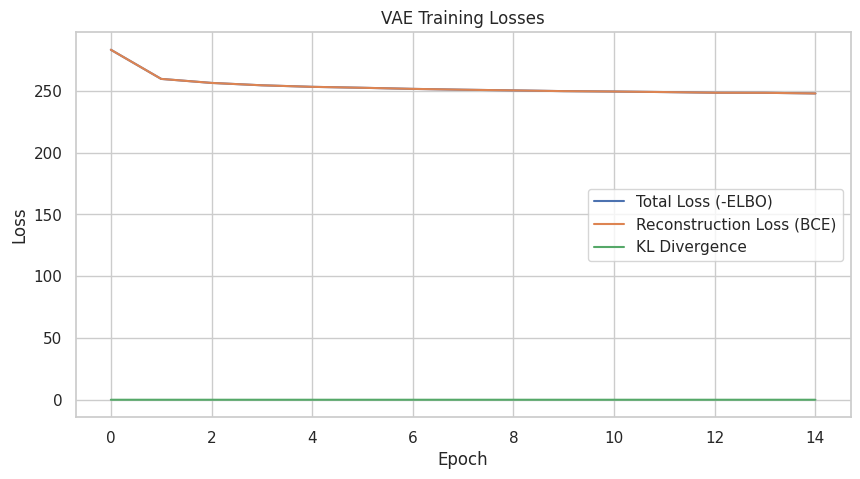

In [77]:
plt.figure(figsize=(10, 5))
plt.plot(train_total_losses, label='Total Loss (-ELBO)')
plt.plot(train_recon_losses, label='Reconstruction Loss (BCE)')
plt.plot(train_kl_divs, label='KL Divergence')
plt.title("VAE Training Losses")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [78]:
# Visualizing VAE Results
vae_model.eval()
test_dataiter_vae_viz = iter(test_loader)
test_images_vae_viz, _ = next(test_dataiter_vae_viz)
test_images_flat_viz = test_images_vae_viz.view(test_images_vae_viz.size(0), -1).to(device)

with torch.no_grad():
    reconstructed_images_vae_viz, _, _, _ = vae_model(test_images_flat_viz)

In [79]:
reconstructed_images_vae_viz = reconstructed_images_vae_viz.view(-1, img_channels, img_height, img_width).cpu()
test_images_to_show_vae = test_images_vae_viz[:10].cpu() # Show first 10

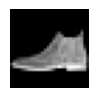

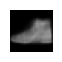

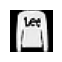

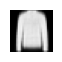

<Figure size 640x480 with 0 Axes>

In [80]:
plt.figure(figsize=(10 * 1.2, 2 * 1.2))
for i in range(2):
    plt.subplot(2, 10, i + 1)
    imshow_vae(test_images_to_show_vae[i], num_images=1) 
    if i == 0: 
        plt.ylabel("Original", rotation=0, size='large', labelpad=30, ha='right')
    
    plt.subplot(2, 10, i + 1 + 10)
    imshow_vae(reconstructed_images_vae_viz[i], num_images=1)
    if i == 0: 
        plt.ylabel("Reconstructed", rotation=0, size='large', labelpad=40, ha='right')
plt.tight_layout()
plt.show()



--- Generating New Images from Latent Space Samples ---


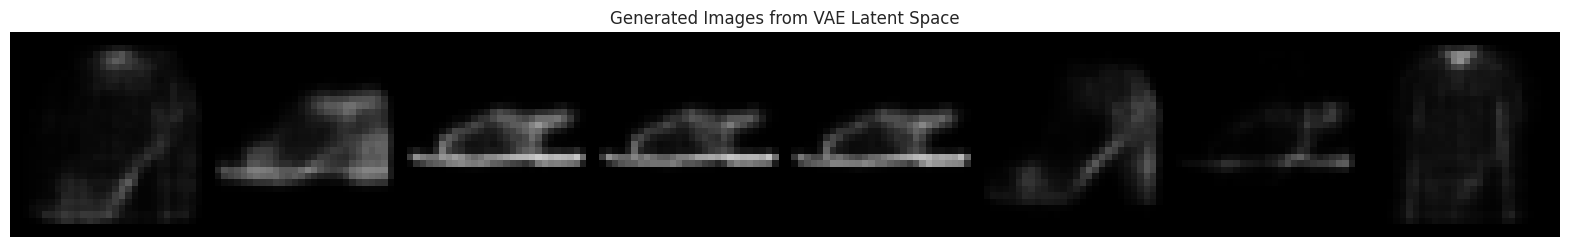

In [81]:
print("\n--- Generating New Images from Latent Space Samples ---")
vae_model.eval()
num_generated_samples = 8
with torch.no_grad():
    # Sample z from N(0, I)
    latent_samples_z = torch.randn(num_generated_samples, latent_dim).to(device)
    generated_images = vae_model.decode(latent_samples_z) # Pass through decoder
    generated_images = generated_images.view(-1, img_channels, img_height, img_width).cpu()

plt.figure(figsize=(20, 8))
imshow_vae(generated_images, title="Generated Images from VAE Latent Space", num_images=num_generated_samples, recon=True)


--- Visualizing 2D Latent Space (VAE) ---


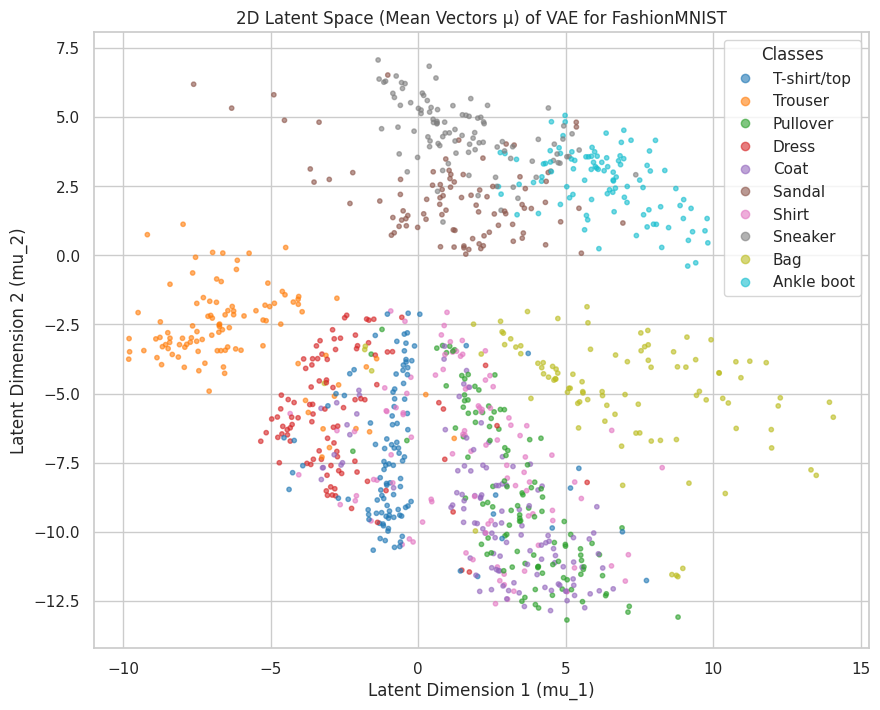

In [84]:
# Visualizing 2D Latent Space 
if latent_dim == 2:
    print(f"\n--- Visualizing 2D Latent Space (VAE) ---")
    vae_model.eval()
    all_latent_mu = []
    all_labels_viz = []
    with torch.no_grad():
        for i, (images, labels) in enumerate(test_loader):
            if i * batch_size > 1000: break # Limit to ~1000 samples for viz
            images_flat = images.view(images.size(0), -1).to(device)
            mu, log_var = vae_model.encode(images_flat) 
            all_latent_mu.append(mu.cpu())
            all_labels_viz.append(labels.cpu())
                
    all_latent_mu_tensor = torch.cat(all_latent_mu, dim=0)
    all_labels_tensor_viz = torch.cat(all_labels_viz, dim=0)

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(all_latent_mu_tensor[:, 0].numpy(), all_latent_mu_tensor[:, 1].numpy(),
                          c=all_labels_tensor_viz.numpy(), cmap='tab10', alpha=0.6, s=10)
    plt.xlabel("Latent Dimension 1 (mu_1)")
    plt.ylabel("Latent Dimension 2 (mu_2)")
    class_names_fm = test_dataset.classes 
    plt.legend(handles=scatter.legend_elements()[0], labels=class_names_fm, title="Classes")
    plt.title("2D Latent Space (Mean Vectors μ) of VAE for FashionMNIST"); plt.show()
else:
    print(f"\nLatent space dimension is {latent_dim}. Visualization of latent space is for 2D.")